In [1]:
from models.cnn_models import EEGNet, ShallowConvNet, DeepConvNet
from utils.plots import plot_acc_loss_keras
from utils.dataloader import load_eeg_data_edf, load_eeg_data_gdf, load_eeg_data_mat
from utils.dataloader import load_eeg_data_mat
from tensorflow.keras import utils as np_utils
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10102586472546742722
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5757075456
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10836572075506523365
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
metrics_results = []

In [4]:
def run_pipeline(x_data, y_data, nb_classes, chans, samples, dataset, subject, metrics_results, kernels=1, epochs=300):
    
    # take 50/25/25 percent of the data to train/validate/test
    X_train, X_aux, Y_train, y_aux = train_test_split( x_data, y_data, test_size=0.5, random_state=42)
    X_validate, X_test, Y_validate, Y_test = train_test_split( X_aux, y_aux, test_size=0.5, random_state=42)

    Y_train      = np_utils.to_categorical(Y_train)
    Y_validate   = np_utils.to_categorical(Y_validate)
    Y_test       = np_utils.to_categorical(Y_test)

    X_train      = X_train.reshape(X_train.shape[0], chans, samples, kernels)
    X_validate   = X_validate.reshape(X_validate.shape[0], chans, samples, kernels)
    X_test       = X_test.reshape(X_test.shape[0], chans, samples, kernels)


    # print('X_train shape:', X_train.shape)
    # print(X_train.shape[0], 'train samples')
    # print(X_test.shape[0], 'test samples')


     

    if nb_classes == 2:
         class_weights = {0:1, 1:1}
    if nb_classes == 3:
         class_weights = {0:1, 1:1, 2:1}
    if nb_classes == 4:
         class_weights = {0:1, 1:1, 2:1, 3:1}
    if nb_classes == 5:
         class_weights = {0:1, 1:1, 2:1, 3:1, 4:1}

    #-------------------------   EEGNet ---------------------------------------------------

    model = EEGNet(nb_classes = nb_classes, Chans = chans, Samples = samples, 
                dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, 
                dropoutType = 'Dropout')

    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics = ['accuracy'])

    numParams    = model.count_params()

    

    fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = epochs, 
                            verbose = 2, validation_data=(X_validate, Y_validate), class_weight = class_weights)

    probs       = model.predict(X_test)
    preds       = probs.argmax(axis = -1)  
    acc         = np.mean(preds == Y_test.argmax(axis=-1))
    print("Classification accuracy: %f " % (acc))

    plot_acc_loss_keras(fittedModel, Y_test.argmax(axis=-1), preds)

    metrics_results.append({
        "model": "EEGNet",
        "dataset": dataset,
        "subject": subject,
        "acc_train": fittedModel.history['accuracy'][-1],
        "acc_val": fittedModel.history['val_accuracy'][-1],
        "acc_test": acc,
    })

    #-------------------------   ShallowConvNet ---------------------------------------------------
    model = ShallowConvNet(nb_classes = nb_classes, Chans = chans, Samples = samples)

    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics = ['accuracy'])

    numParams    = model.count_params()

   

    fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = epochs, 
                            verbose = 2, validation_data=(X_validate, Y_validate), class_weight = class_weights)

    probs       = model.predict(X_test)
    preds       = probs.argmax(axis = -1)  
    acc         = np.mean(preds == Y_test.argmax(axis=-1))
    print("Classification accuracy: %f " % (acc))

    plot_acc_loss_keras(fittedModel, Y_test.argmax(axis=-1), preds)

    metrics_results.append({
        "model": "ShallowConvNet",
        "dataset": dataset,
        "subject": subject,
        "acc_train": fittedModel.history['accuracy'][-1],
        "acc_val": fittedModel.history['val_accuracy'][-1],
        "acc_test": acc,
    })

    #-------------------------   DeepConvNet ---------------------------------------------------


    model = DeepConvNet(nb_classes = nb_classes, Chans = chans, Samples = samples)

    model.compile(loss='categorical_crossentropy', optimizer='adam', 
                metrics = ['accuracy'])

    numParams    = model.count_params()

    

    fittedModel = model.fit(X_train, Y_train, batch_size = 16, epochs = epochs, 
                            verbose = 2, validation_data=(X_validate, Y_validate), class_weight = class_weights)

    probs       = model.predict(X_test)
    preds       = probs.argmax(axis = -1)  
    acc         = np.mean(preds == Y_test.argmax(axis=-1))
    print("Classification accuracy: %f " % (acc))

    plot_acc_loss_keras(fittedModel, Y_test.argmax(axis=-1), preds)

    metrics_results.append({
        "model": "DeepConvNet",
        "dataset": dataset,
        "subject": subject,
        "acc_train": fittedModel.history['accuracy'][-1],
        "acc_val": fittedModel.history['val_accuracy'][-1],
        "acc_test": acc,
    })


## Dataset A

### 1. Training all subjects' data at once

Shape of EEG: (59, 190594)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'foot']
Number of classes: 2
Shape of trials[cl1]: (100, 59, 200)
Shape of trials[cl2]: (100, 59, 200)
Shape of EEG: (59, 190594)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 

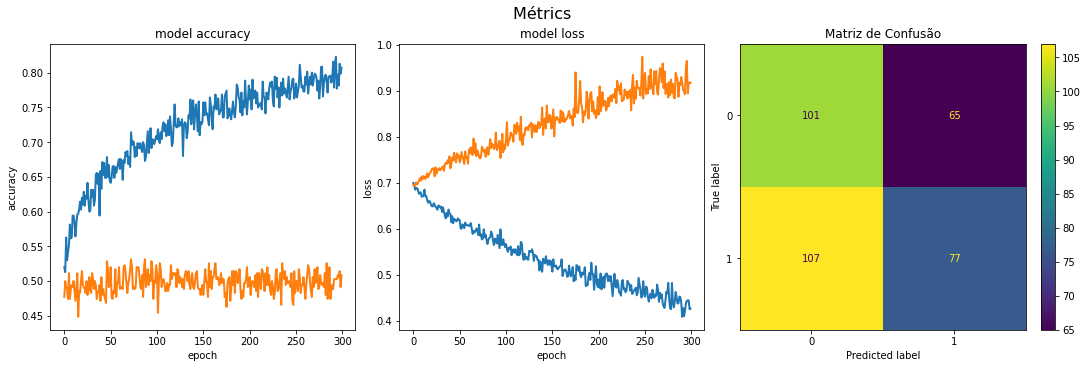

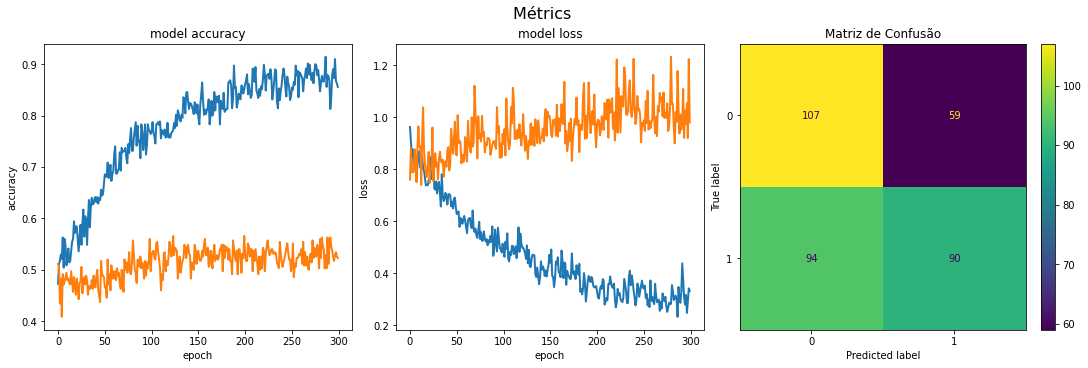

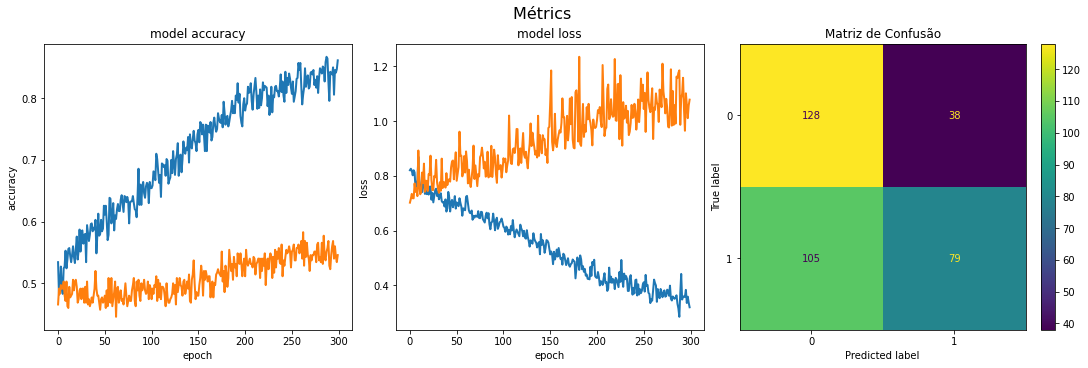

In [5]:
directory = 'C:/Users/Maods/Documents/TCC/data/BCICIV_1_mat/'
ext = '*.mat'
x_mat,y_mat = load_eeg_data_mat(directory, ext)
nb_classes = np.unique(y_mat).shape[0]
_, channels, samples = np.shape(x_mat)
run_pipeline(x_mat, y_mat, nb_classes=nb_classes, chans=channels, samples=samples, dataset="BCICIV_I", subject="all", metrics_results=metrics_results, kernels=1, epochs=300)

### 2. Training the subjects' data separately

Shape of EEG: (59, 190594)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events: 1
Event codes: [-1  1]
Class labels: ['left', 'foot']
Number of classes: 2
Shape of trials[cl1]: (100, 59, 200)
Shape of trials[cl2]: (100, 59, 200)
Epoch 1/300
7/7 - 2s - loss: 0.6947 - accuracy: 0.4700 - val_loss: 0.7050 - val_accuracy: 0.5000 - 2s/epoch - 338ms/step
Epoch 2/300
7/7 - 0s - loss: 0.7069 - accuracy: 0.4500 - val_loss: 0.6966 - val_accuracy: 0.5200 - 120ms/epoch - 17ms/step
Epoch 3/300
7/7 - 0s - loss: 0.6862 - accuracy: 0.5600 - val_loss: 0.6956 - val_accuracy: 0.5400 - 211

2/2 [==============================] - 0s 3ms/step
Classification accuracy: 0.500000 
Epoch 1/300
7/7 - 2s - loss: 1.1215 - accuracy: 0.4700 - val_loss: 0.7333 - val_accuracy: 0.5600 - 2s/epoch - 284ms/step
Epoch 2/300
7/7 - 0s - loss: 0.8341 - accuracy: 0.5700 - val_loss: 0.8109 - val_accuracy: 0.4600 - 267ms/epoch - 38ms/step
Epoch 3/300
7/7 - 0s - loss: 0.8788 - accuracy: 0.5900 - val_loss: 0.8522 - val_accuracy: 0.5400 - 135ms/epoch - 19ms/step
Epoch 4/300
7/7 - 0s - loss: 0.8546 - accuracy: 0.5900 - val_loss: 0.8731 - val_accuracy: 0.5400 - 169ms/epoch - 24ms/step
Epoch 5/300
7/7 - 0s - loss: 0.6799 - accuracy: 0.6200 - val_loss: 1.0120 - val_accuracy: 0.5000 - 164ms/epoch - 23ms/step
Epoch 6/300
7/7 - 0s - loss: 0.6706 - accuracy: 0.6800 - val_loss: 0.7923 - val_accuracy: 0.4800 - 131ms/epoch - 19ms/step
Epoch 7/300
7/7 - 0s - loss: 0.6414 - accuracy: 0.6900 - val_loss: 0.9558 - val_accuracy: 0.5200 - 192ms/epoch - 27ms/step
Epoch 8/300
7/7 - 0s - loss: 0.8246 - accuracy: 0.6200 

2/2 [==============================] - 0s 3ms/step
Classification accuracy: 0.360000 
Epoch 1/300
7/7 - 2s - loss: 0.8984 - accuracy: 0.5300 - val_loss: 0.9179 - val_accuracy: 0.4800 - 2s/epoch - 308ms/step
Epoch 2/300
7/7 - 0s - loss: 0.8074 - accuracy: 0.4900 - val_loss: 0.6985 - val_accuracy: 0.5000 - 184ms/epoch - 26ms/step
Epoch 3/300
7/7 - 0s - loss: 0.8333 - accuracy: 0.5700 - val_loss: 0.6973 - val_accuracy: 0.5400 - 246ms/epoch - 35ms/step
Epoch 4/300
7/7 - 0s - loss: 0.7184 - accuracy: 0.5800 - val_loss: 0.6511 - val_accuracy: 0.6400 - 159ms/epoch - 23ms/step
Epoch 5/300
7/7 - 0s - loss: 0.7293 - accuracy: 0.6300 - val_loss: 0.6827 - val_accuracy: 0.5800 - 197ms/epoch - 28ms/step
Epoch 6/300
7/7 - 0s - loss: 0.6240 - accuracy: 0.6700 - val_loss: 0.8237 - val_accuracy: 0.5000 - 174ms/epoch - 25ms/step
Epoch 7/300
7/7 - 0s - loss: 0.6696 - accuracy: 0.6700 - val_loss: 0.6384 - val_accuracy: 0.6400 - 145ms/epoch - 21ms/step
Epoch 8/300
7/7 - 0s - loss: 0.6313 - accuracy: 0.7000 

c:\Users\Maods\Documents\Repos\EEG-Analysis-\src\utils\plots.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15,5))


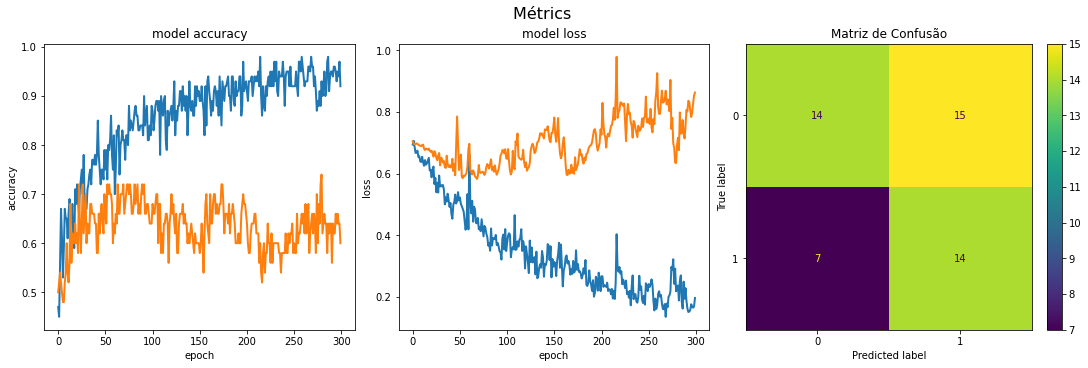

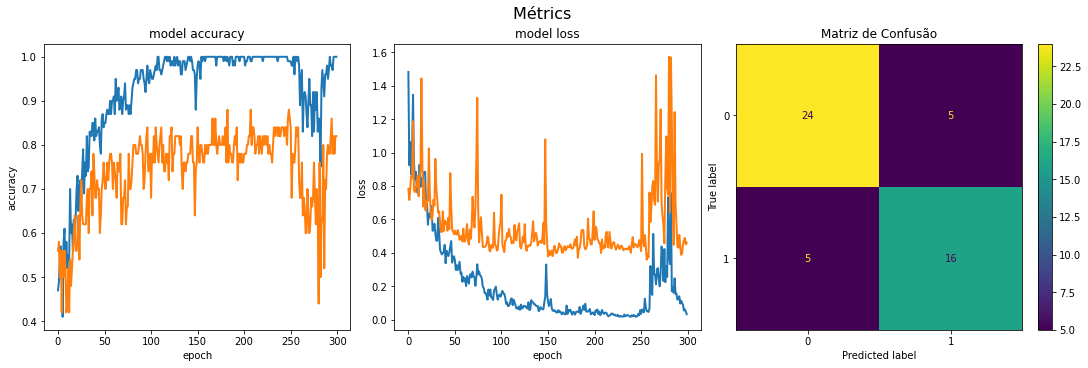

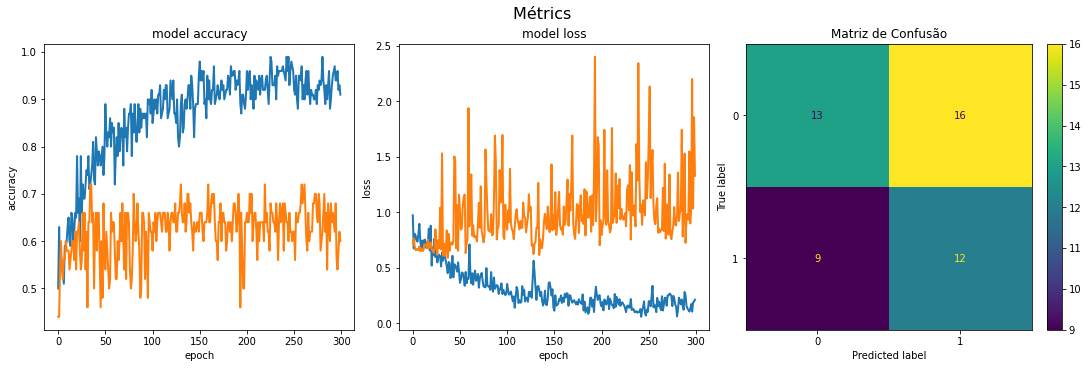

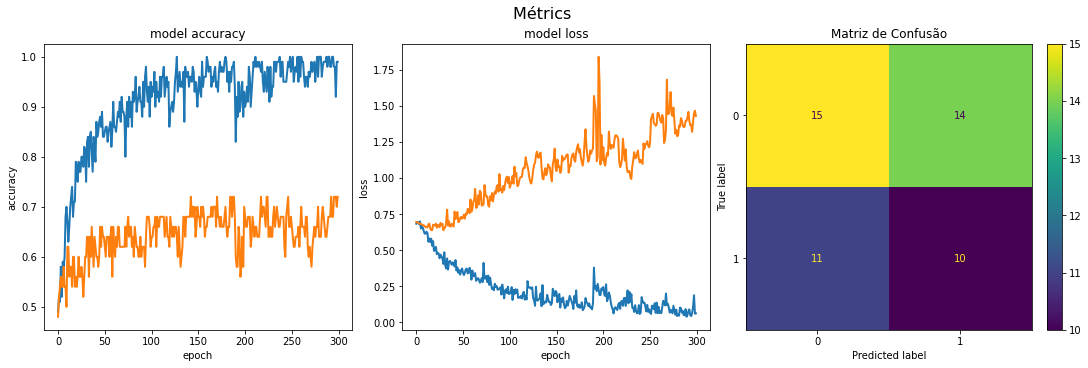

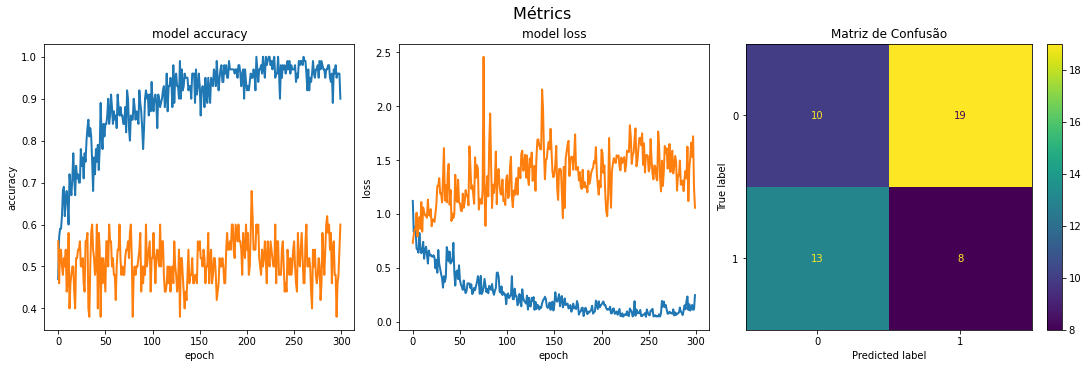

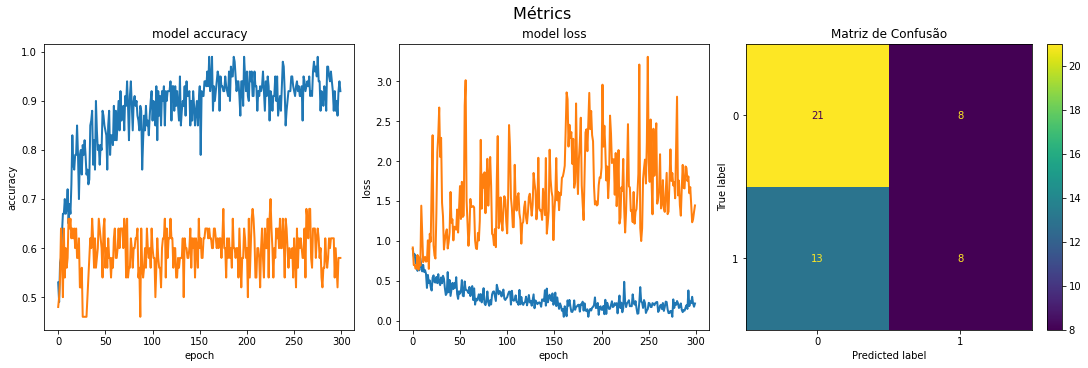

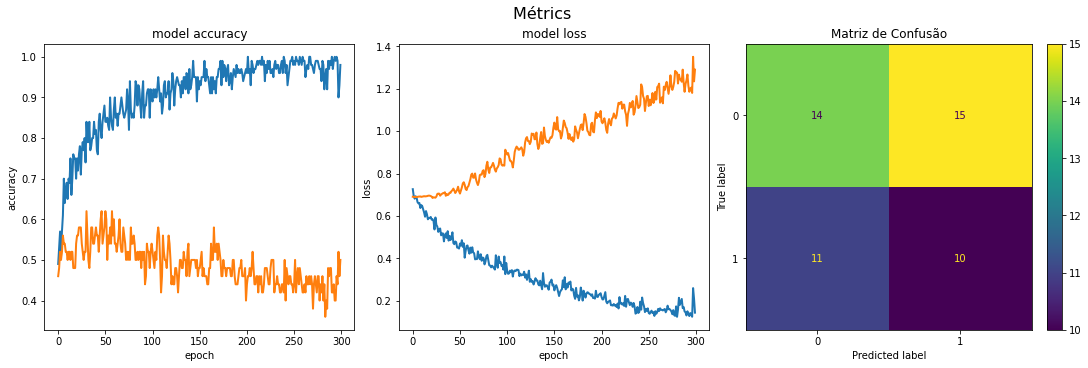

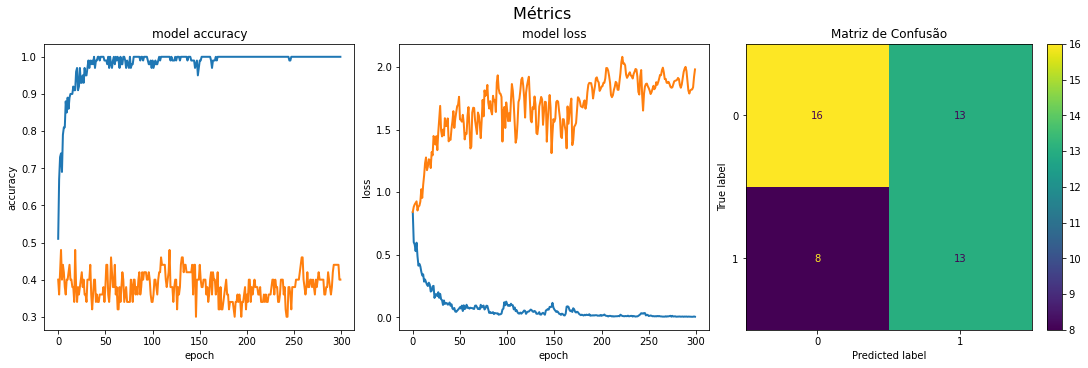

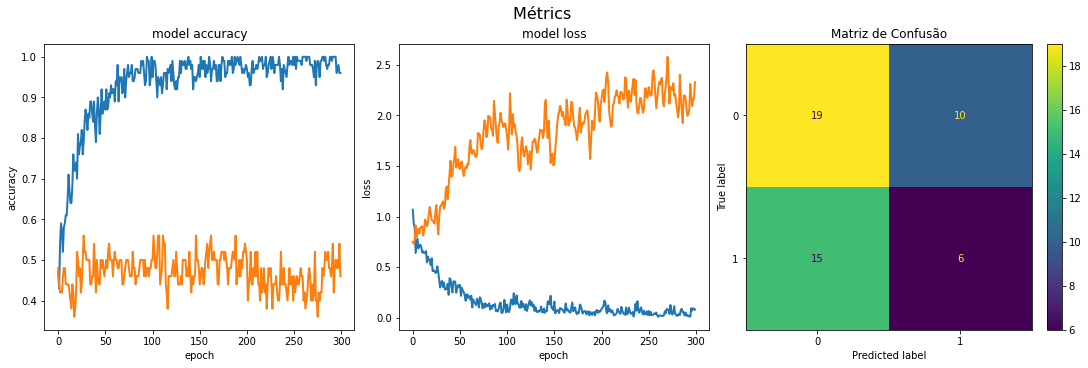

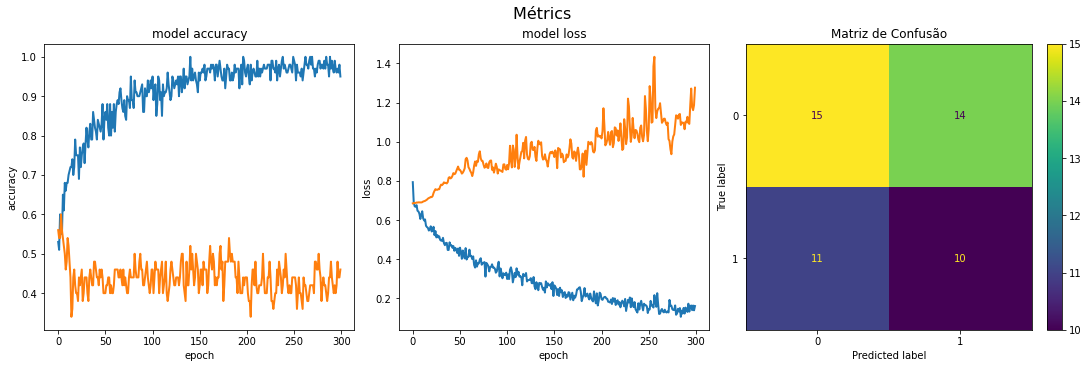

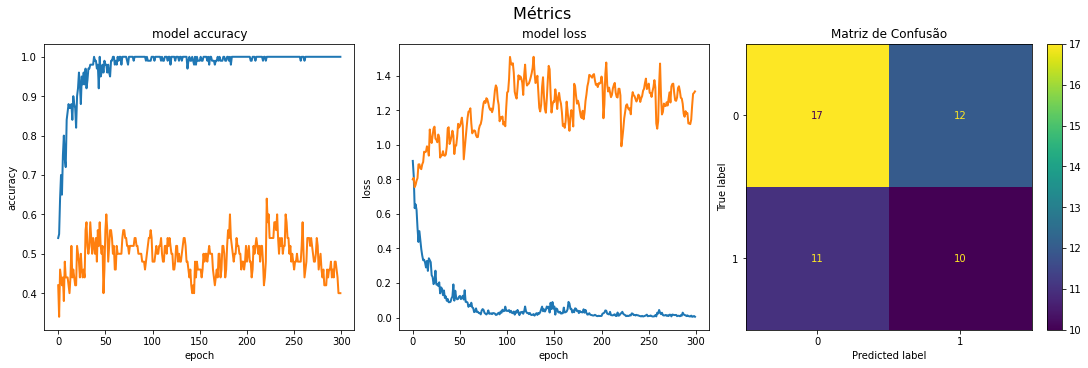

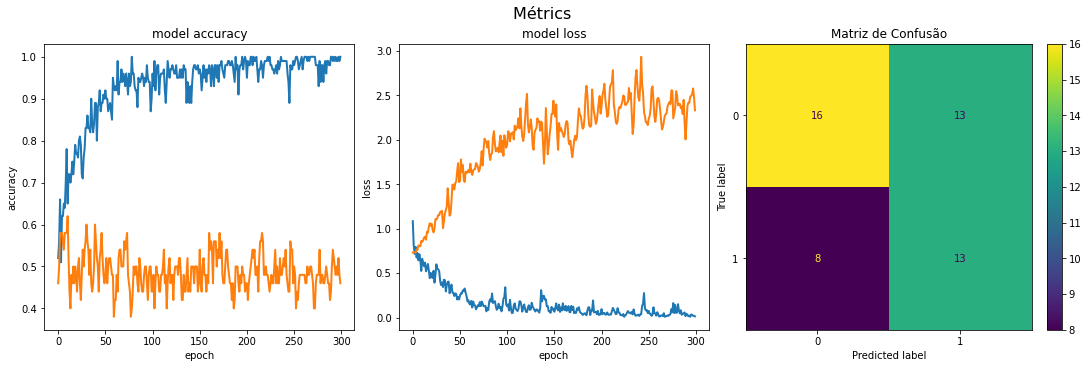

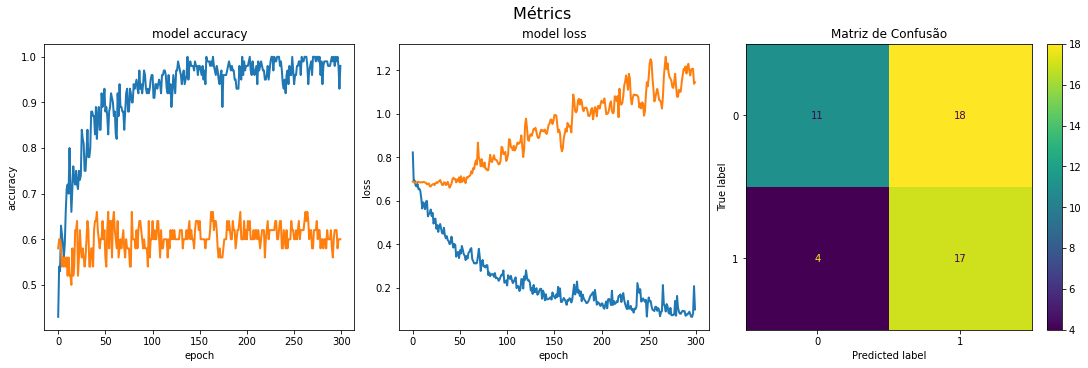

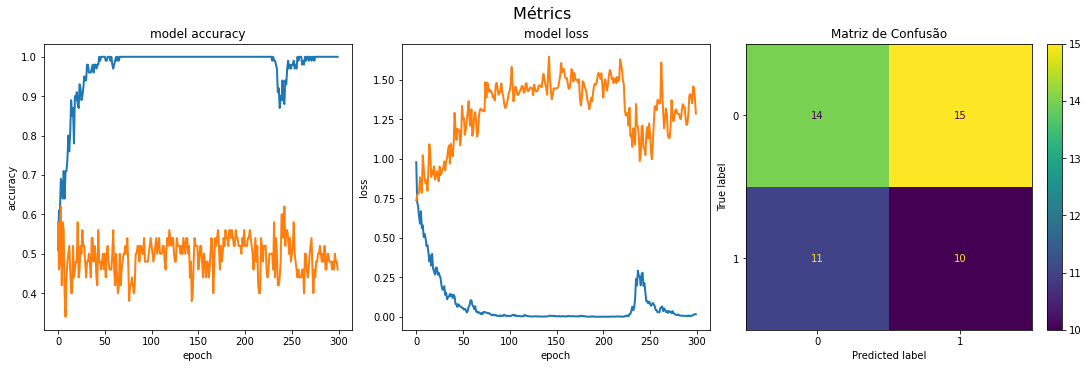

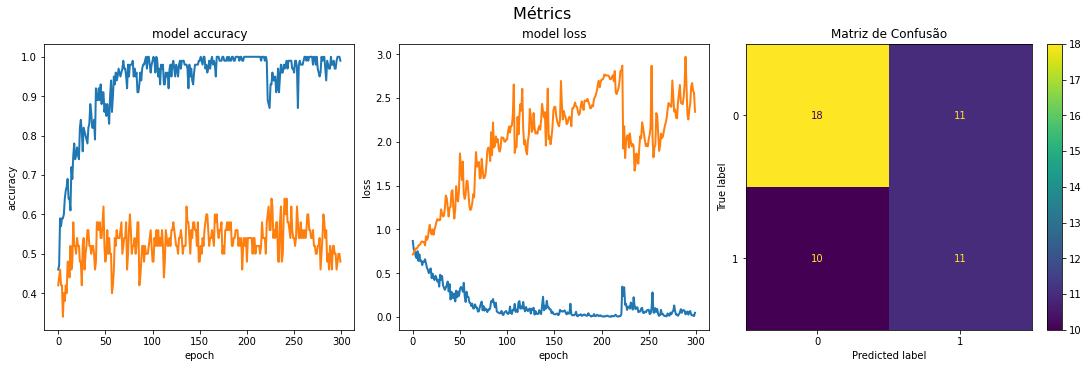

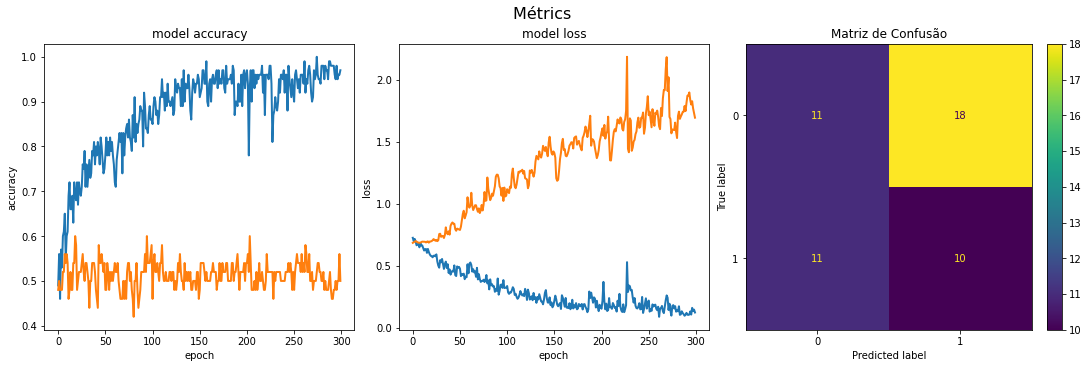

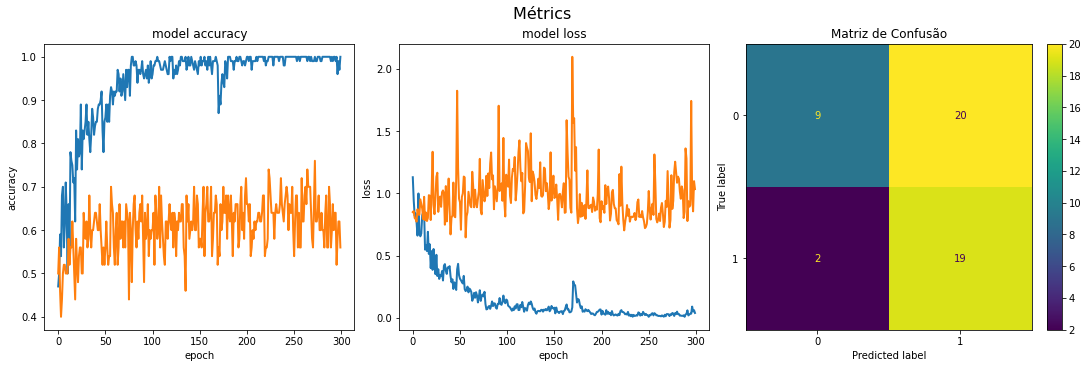

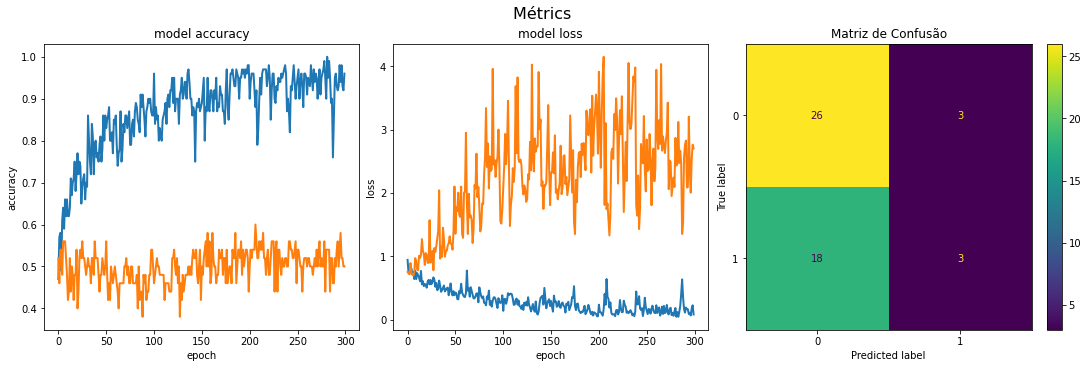

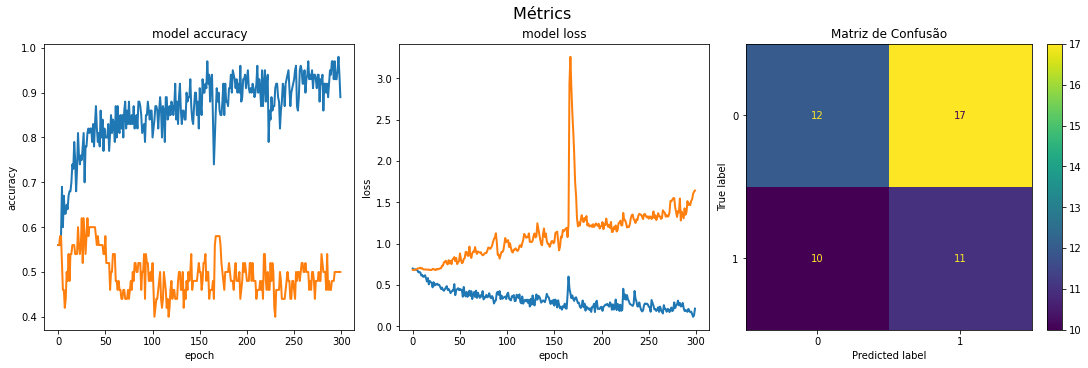

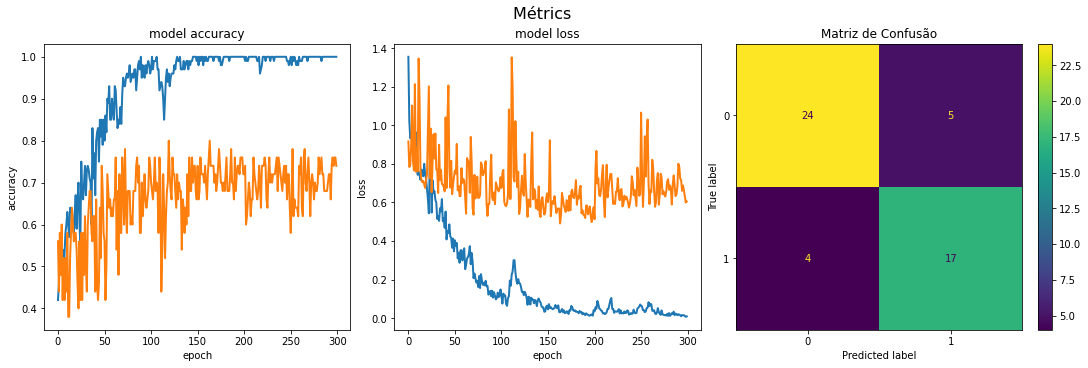

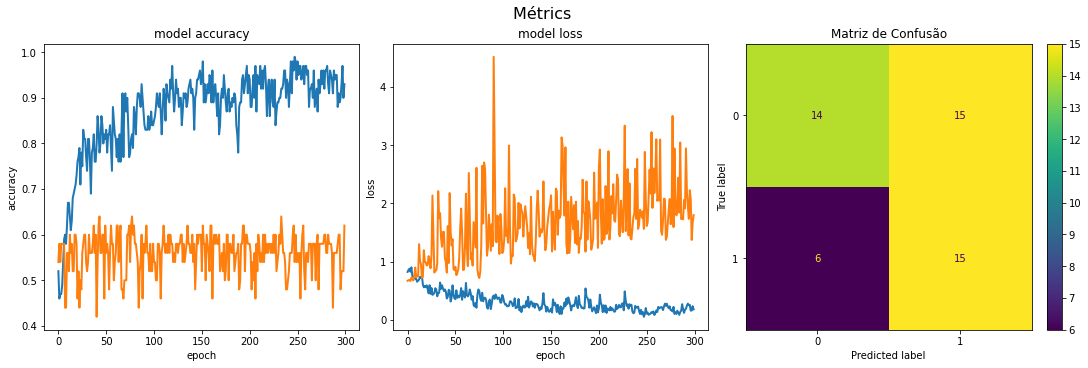

In [6]:
directory = 'C:/Users/Maods/Documents/TCC/data/BCICIV_1_mat/'
files = [ file.stem for file in Path(directory).glob('*.mat')]
for file in files:
    extension = file + '.mat'
    x_mat,y_mat = load_eeg_data_mat(directory, extension)
    if  np.shape(x_mat)[0] == 0:
        continue
    
    nb_classes = np.unique(y_mat).shape[0]
    _, channels, samples = np.shape(x_mat)
    run_pipeline(x_mat, y_mat, nb_classes=nb_classes, chans=channels, samples=samples, dataset="BCICIV_I", subject=file, metrics_results=metrics_results, kernels=1, epochs=300)

## Dataset B

### 1. Training all subjects' data at once

Extracting EDF parameters from C:\Users\Maods\Documents\TCC\data\BCICIV_2a_gdf-dataset\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...


c:\Users\Maods\Documents\Repos\EEG-Analysis-\env_tcc_eeg\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\Maods\.pyenv\pyenv-win\versions\3.9.12\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Reading 0 ... 672527  =      0.000 ...  2690.108 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


c:\Users\Maods\Documents\Repos\EEG-Analysis-\env_tcc_eeg\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\Maods\.pyenv\pyenv-win\versions\3.9.12\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 orig

c:\Users\Maods\Documents\Repos\EEG-Analysis-\env_tcc_eeg\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\Maods\.pyenv\pyenv-win\versions\3.9.12\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Used Annotations descriptions: ['1023', '1072', '32766', '768', '769', '770', '771', '772']
Not setting metadata
144 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 201 original time poin

c:\Users\Maods\Documents\Repos\EEG-Analysis-\src\utils\dataloader.py:28: RuntimeWarning: No matching events found for 9 (event id 9)
  epochs = mne.Epochs(raw, events[0], event_id=[7,8,9,10],on_missing ='warn',tmin= -0.1, tmax=0.7, preload=True)
c:\Users\Maods\Documents\Repos\EEG-Analysis-\src\utils\dataloader.py:28: RuntimeWarning: No matching events found for 10 (event id 10)
  epochs = mne.Epochs(raw, events[0], event_id=[7,8,9,10],on_missing ='warn',tmin= -0.1, tmax=0.7, preload=True)
c:\Users\Maods\Documents\Repos\EEG-Analysis-\env_tcc_eeg\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\Maods\.pyenv\pyenv-win\versions\3.9.12\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 orig

c:\Users\Maods\Documents\Repos\EEG-Analysis-\env_tcc_eeg\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\Maods\.pyenv\pyenv-win\versions\3.9.12\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 orig

c:\Users\Maods\Documents\Repos\EEG-Analysis-\env_tcc_eeg\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\Maods\.pyenv\pyenv-win\versions\3.9.12\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 orig

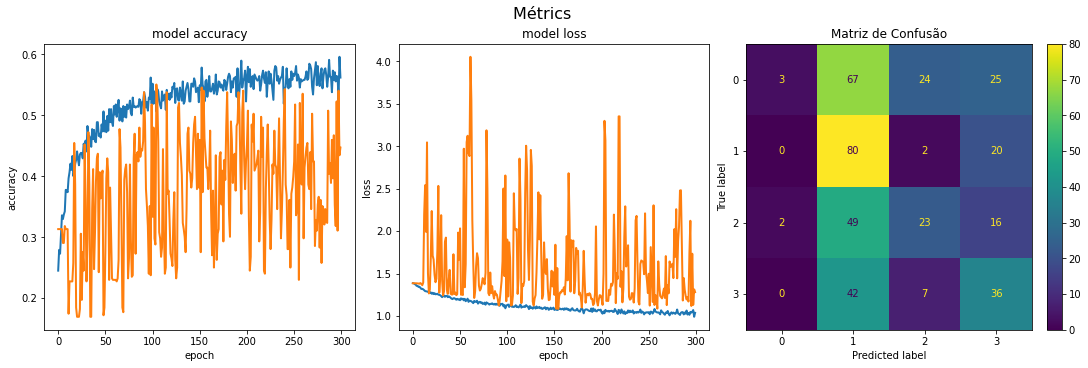

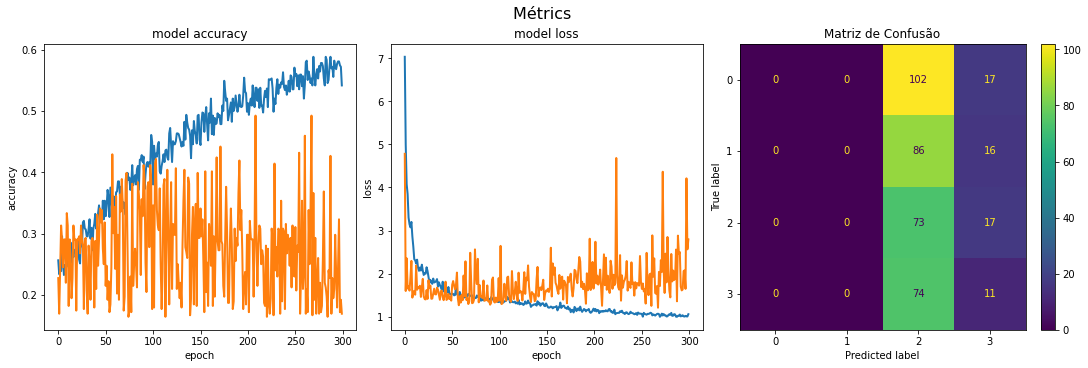

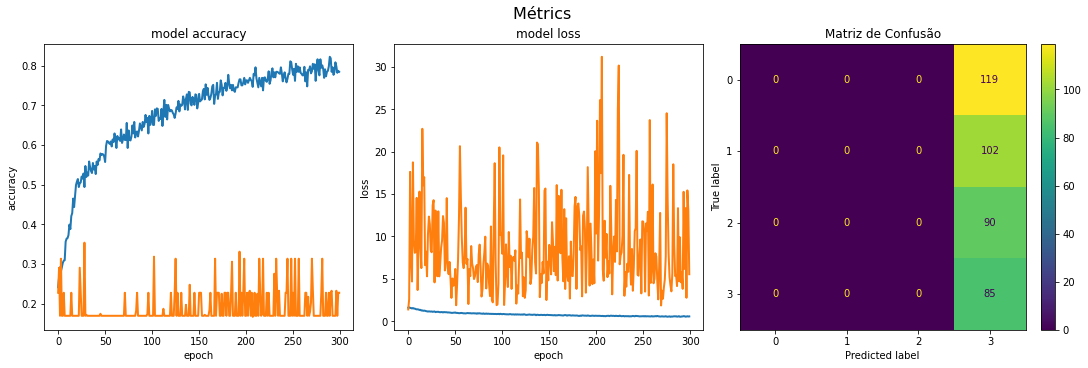

In [7]:
directory = 'C:/Users/Maods/Documents/TCC/data/BCICIV_2a_gdf-dataset/' 
extension = '*T.gdf'


x_train_BCICIV, y_train_BCICIV = load_eeg_data_gdf(directory, extension)
nb_classes = np.unique(y_train_BCICIV).shape[0]
_, channels, samples = np.shape(x_train_BCICIV)
run_pipeline(x_train_BCICIV, y_train_BCICIV, nb_classes=nb_classes, chans=channels, samples=samples, dataset="BCICIV_II", subject="all", metrics_results=metrics_results, kernels=1, epochs=300)

### 2. Training the subjects' data separately

Extracting EDF parameters from C:\Users\Maods\Documents\TCC\data\BCICIV_2a_gdf-dataset\A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


c:\Users\Maods\Documents\Repos\EEG-Analysis-\env_tcc_eeg\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\Maods\.pyenv\pyenv-win\versions\3.9.12\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 orig

c:\Users\Maods\Documents\Repos\EEG-Analysis-\env_tcc_eeg\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\Maods\.pyenv\pyenv-win\versions\3.9.12\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 orig

c:\Users\Maods\Documents\Repos\EEG-Analysis-\env_tcc_eeg\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\Maods\.pyenv\pyenv-win\versions\3.9.12\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Used Annotations descriptions: ['1023', '1072', '32766', '768', '769', '770', '771', '772']
Not setting metadata
144 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 201 original time poin

c:\Users\Maods\Documents\Repos\EEG-Analysis-\src\utils\dataloader.py:28: RuntimeWarning: No matching events found for 9 (event id 9)
  epochs = mne.Epochs(raw, events[0], event_id=[7,8,9,10],on_missing ='warn',tmin= -0.1, tmax=0.7, preload=True)
c:\Users\Maods\Documents\Repos\EEG-Analysis-\src\utils\dataloader.py:28: RuntimeWarning: No matching events found for 10 (event id 10)
  epochs = mne.Epochs(raw, events[0], event_id=[7,8,9,10],on_missing ='warn',tmin= -0.1, tmax=0.7, preload=True)


Epoch 1/300
5/5 - 1s - loss: 0.6923 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4444 - 1s/epoch - 206ms/step
Epoch 2/300
5/5 - 0s - loss: 0.6924 - accuracy: 0.5417 - val_loss: 0.6935 - val_accuracy: 0.4444 - 157ms/epoch - 31ms/step
Epoch 3/300
5/5 - 0s - loss: 0.6911 - accuracy: 0.5833 - val_loss: 0.6938 - val_accuracy: 0.4444 - 83ms/epoch - 17ms/step
Epoch 4/300
5/5 - 0s - loss: 0.6917 - accuracy: 0.5556 - val_loss: 0.6942 - val_accuracy: 0.4444 - 78ms/epoch - 16ms/step
Epoch 5/300
5/5 - 0s - loss: 0.6900 - accuracy: 0.5556 - val_loss: 0.6945 - val_accuracy: 0.4444 - 74ms/epoch - 15ms/step
Epoch 6/300
5/5 - 0s - loss: 0.6882 - accuracy: 0.5972 - val_loss: 0.6947 - val_accuracy: 0.4444 - 65ms/epoch - 13ms/step
Epoch 7/300
5/5 - 0s - loss: 0.6879 - accuracy: 0.5833 - val_loss: 0.6951 - val_accuracy: 0.4444 - 67ms/epoch - 13ms/step
Epoch 8/300
5/5 - 0s - loss: 0.6887 - accuracy: 0.5556 - val_loss: 0.6955 - val_accuracy: 0.4444 - 73ms/epoch - 15ms/step
Epoch 9/300
5/5 - 0s - l

c:\Users\Maods\Documents\Repos\EEG-Analysis-\env_tcc_eeg\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\Maods\.pyenv\pyenv-win\versions\3.9.12\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 orig

c:\Users\Maods\Documents\Repos\EEG-Analysis-\env_tcc_eeg\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\Maods\.pyenv\pyenv-win\versions\3.9.12\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 orig

c:\Users\Maods\Documents\Repos\EEG-Analysis-\env_tcc_eeg\lib\site-packages\mne\io\edf\edf.py:1123: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
C:\Users\Maods\.pyenv\pyenv-win\versions\3.9.12\lib\contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 825 samples (3.300 sec)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']
Not setting metadata
288 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 201 orig

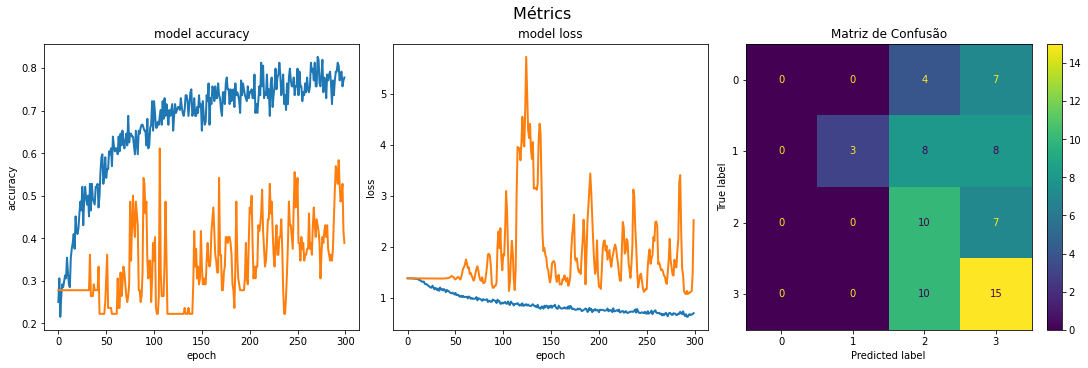

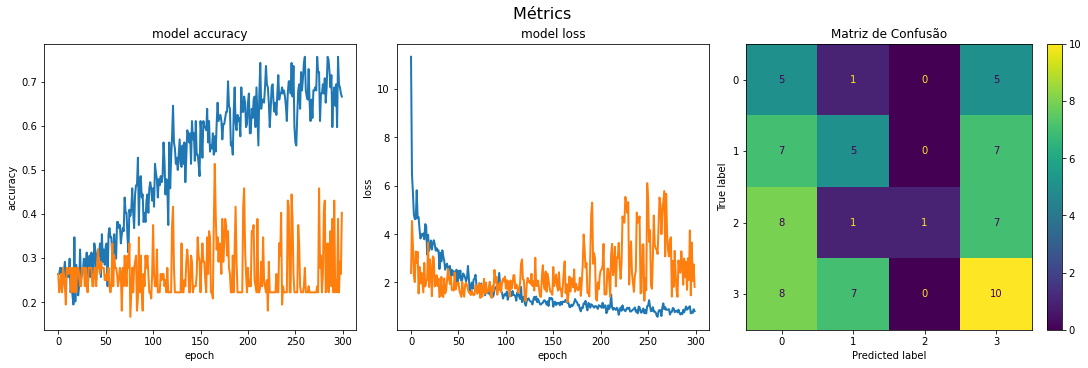

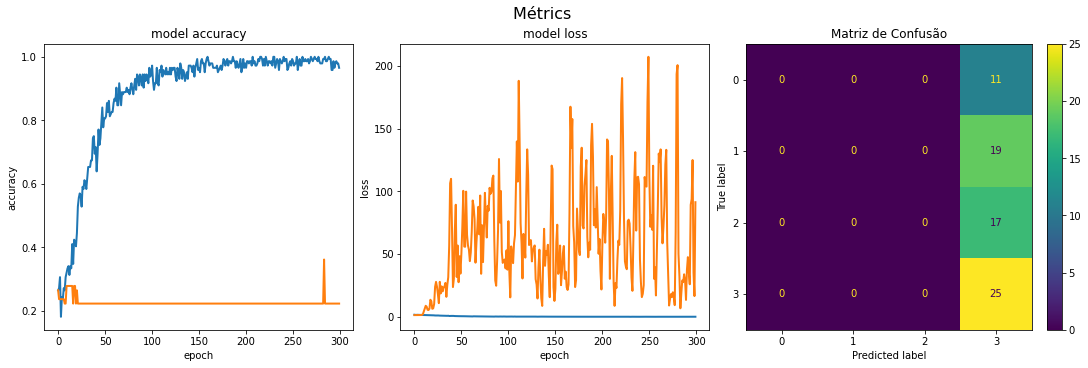

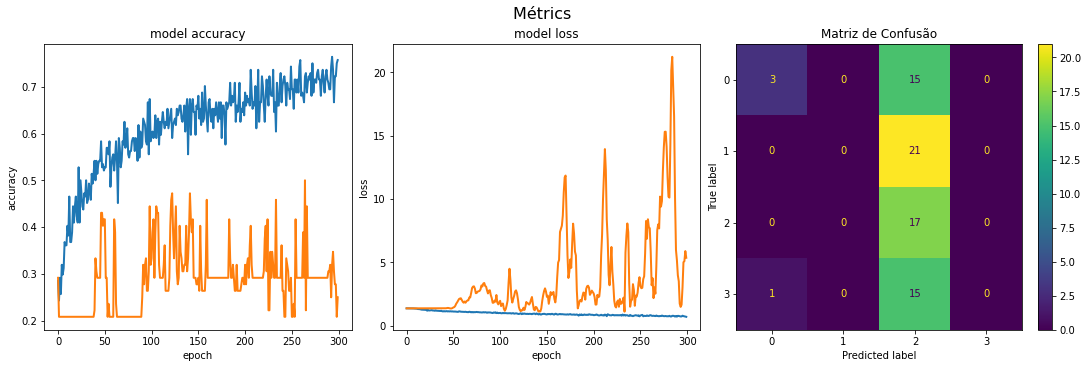

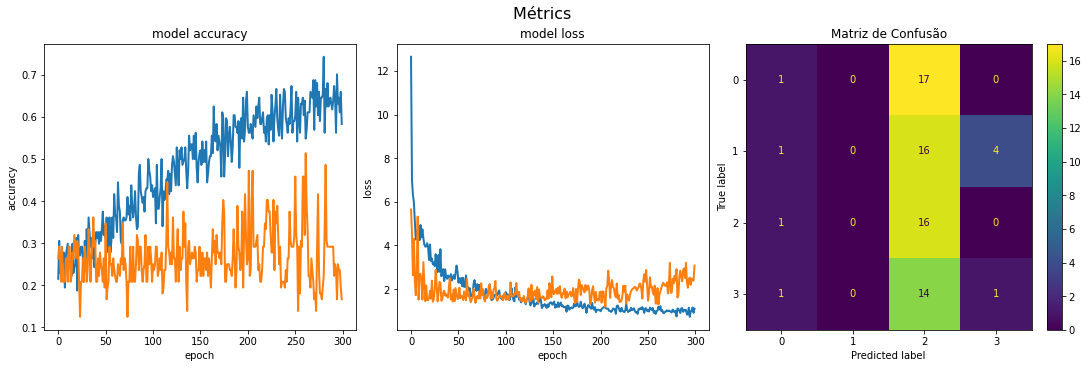

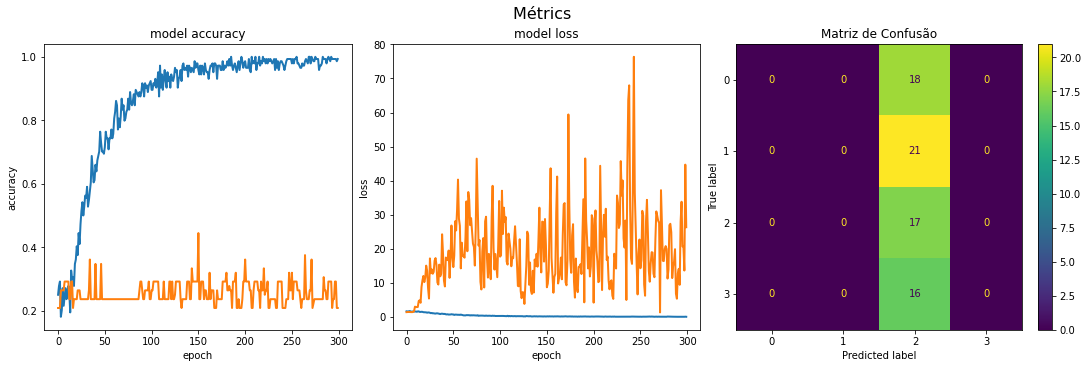

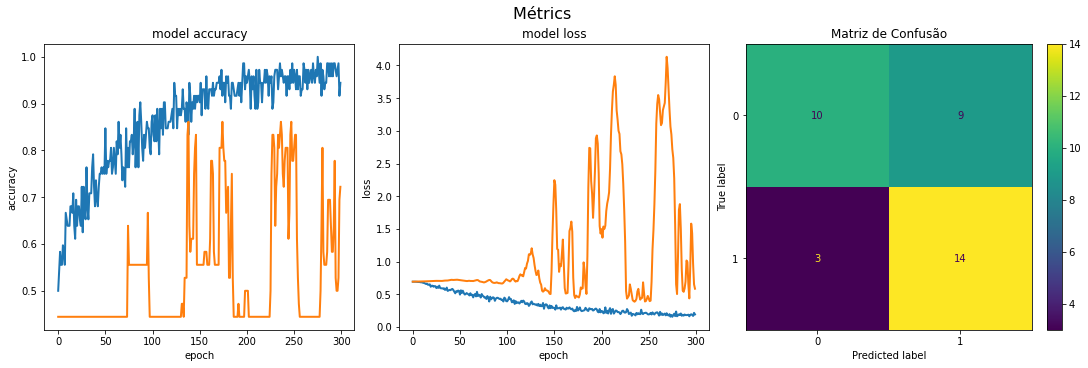

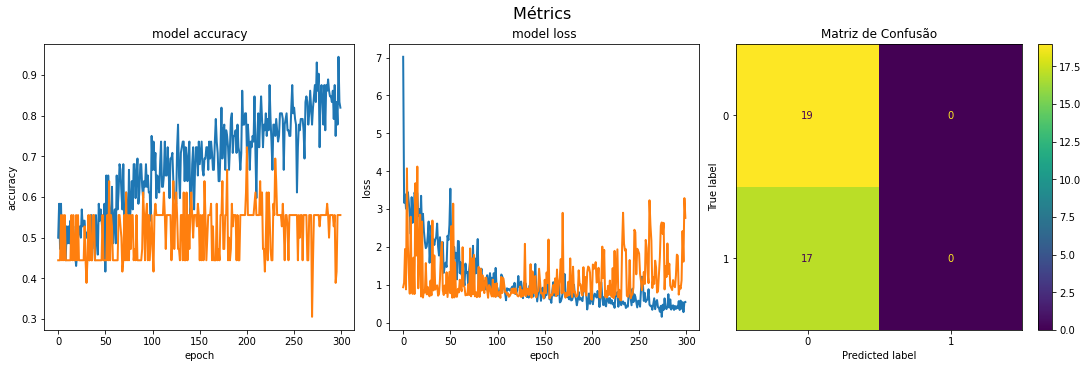

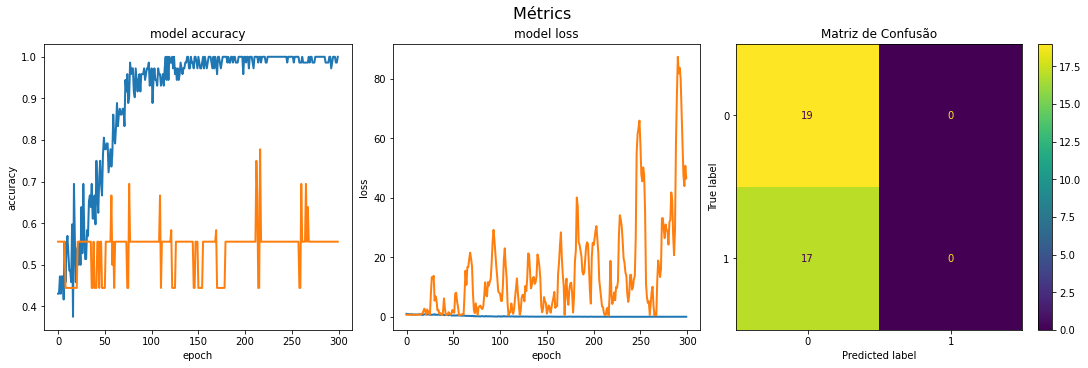

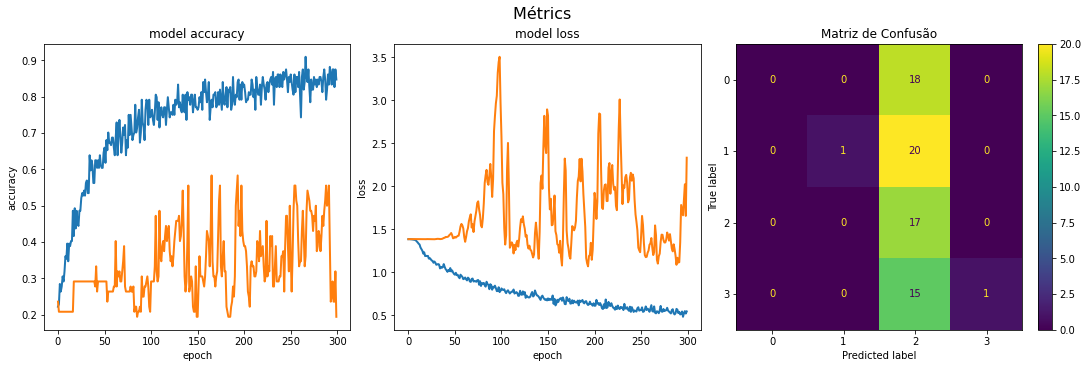

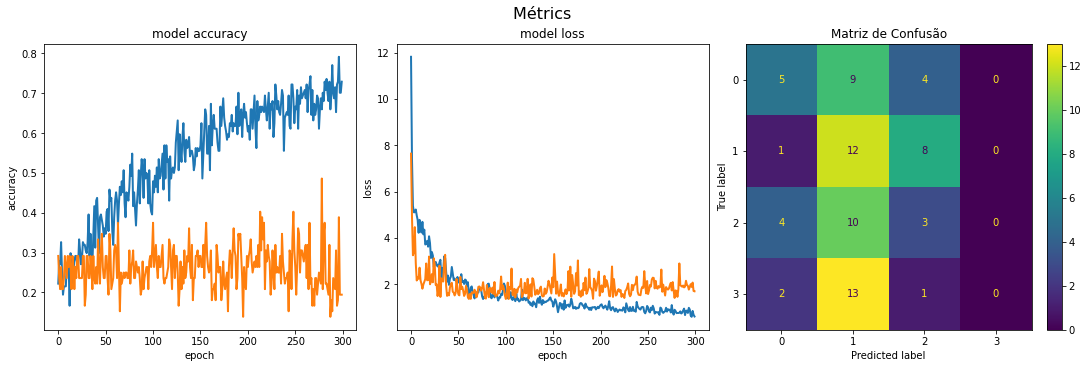

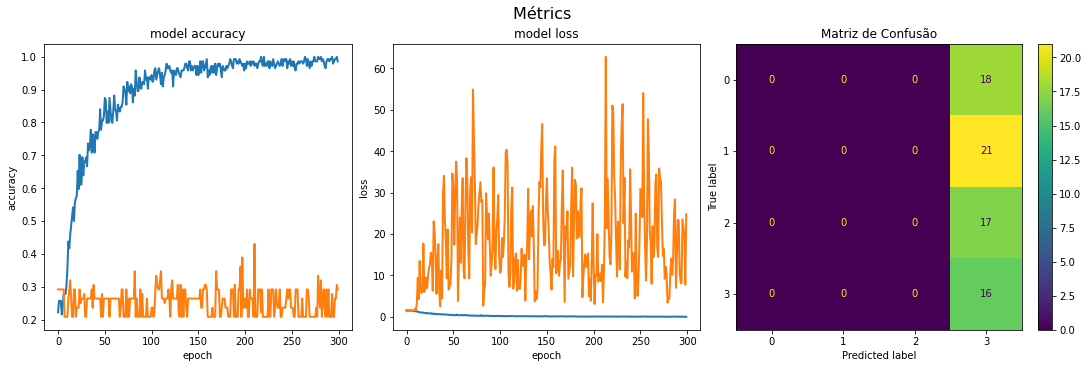

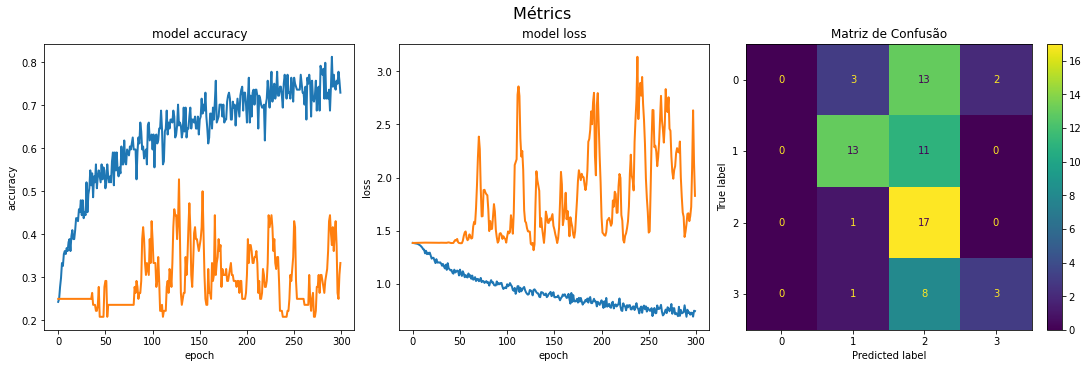

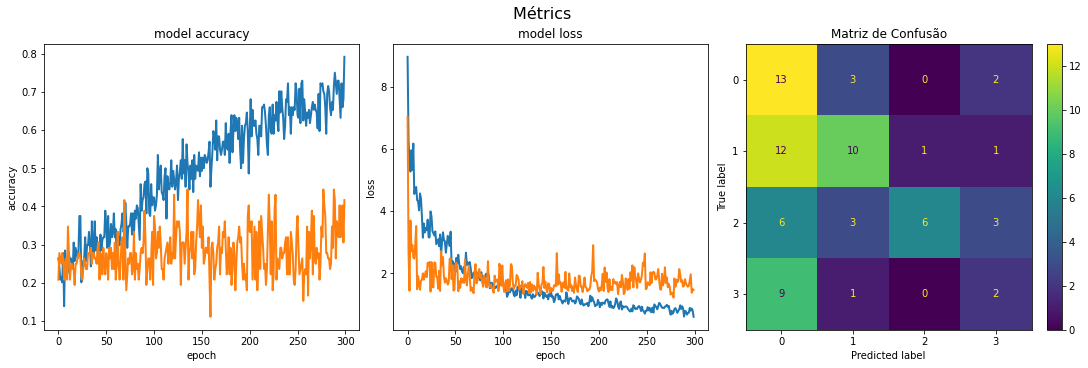

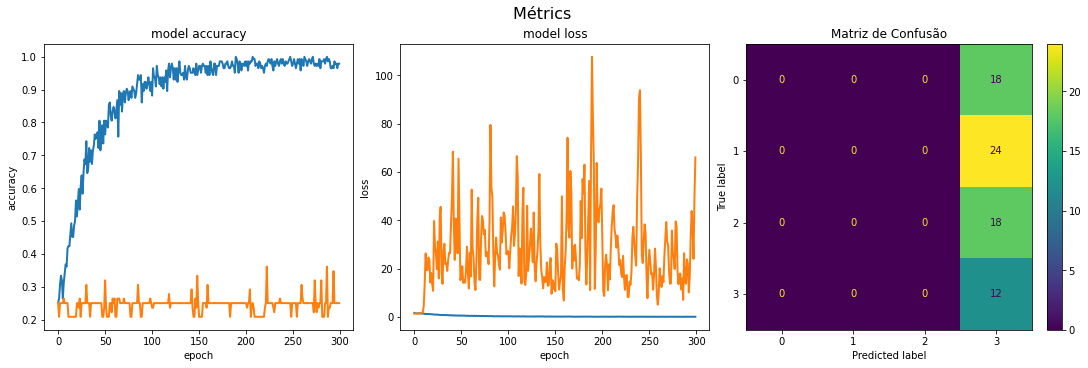

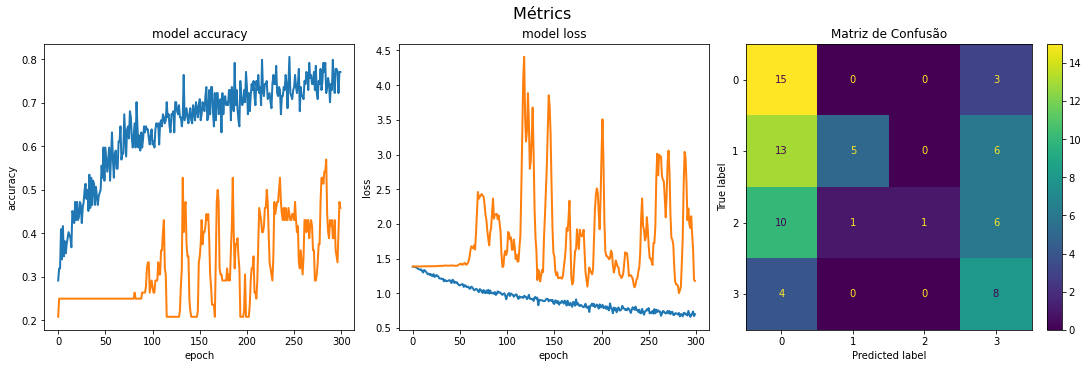

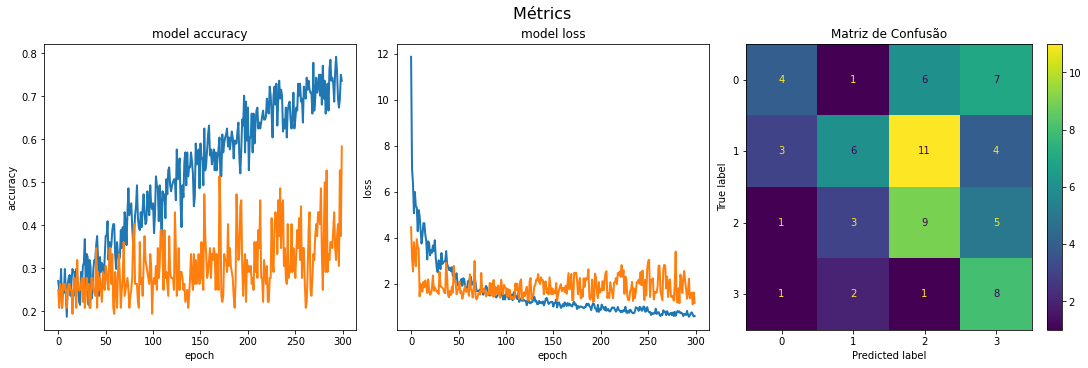

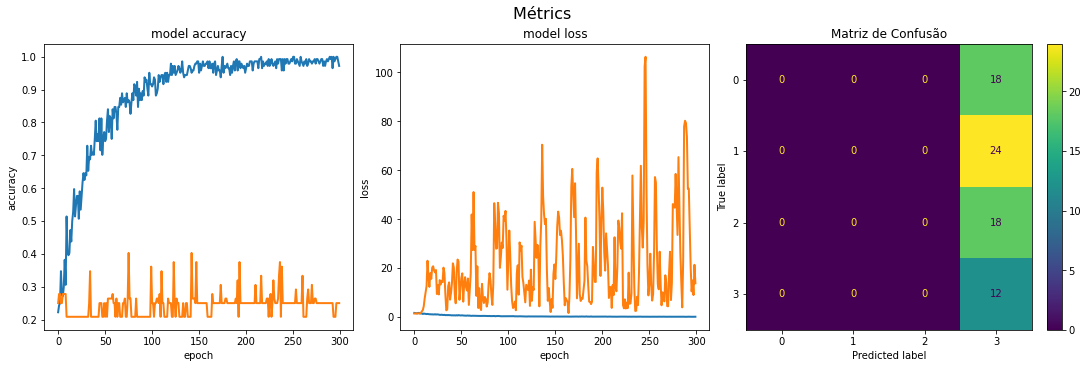

In [8]:
directory = 'C:/Users/Maods/Documents/TCC/data/BCICIV_2a_gdf-dataset/'
files = [ file.stem for file in Path(directory).glob('*T.gdf')]
for file in files:
    extension = file + '.gdf'
    x_train_BCICIV, y_train_BCICIV = load_eeg_data_gdf(directory, extension)
    nb_classes = np.unique(y_train_BCICIV).shape[0]
    _, channels, samples = np.shape(x_train_BCICIV)
    run_pipeline(x_train_BCICIV, y_train_BCICIV, nb_classes=nb_classes, chans=channels, samples=samples, dataset="BCICIV_II", subject=file, metrics_results=metrics_results, kernels=1, epochs=300)

## Dataset C

### 1. Training all subjects' data at once

Extracting EDF parameters from C:\Users\Maods\Documents\TCC\data\eeg-motor-movementimagery-dataset\files\S001\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 113 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\Maods\Documents\TCC\data\eeg-motor-movementimagery-dataset\files\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG channel type selected for re-referencing
Applyi

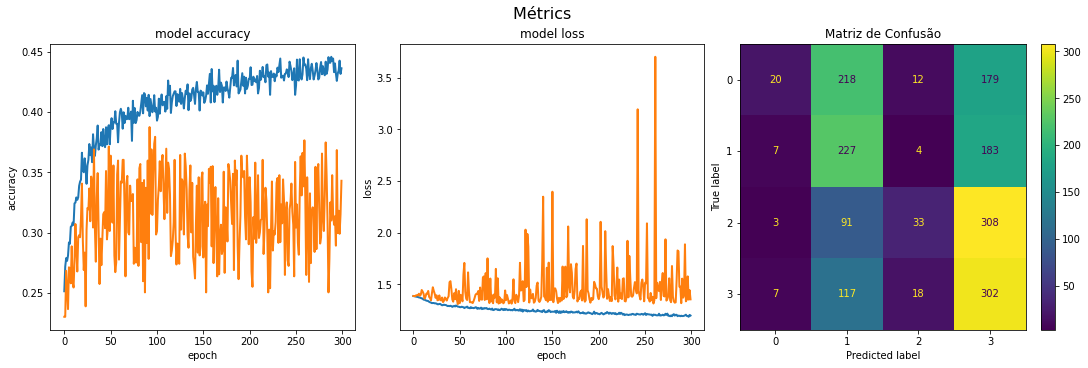

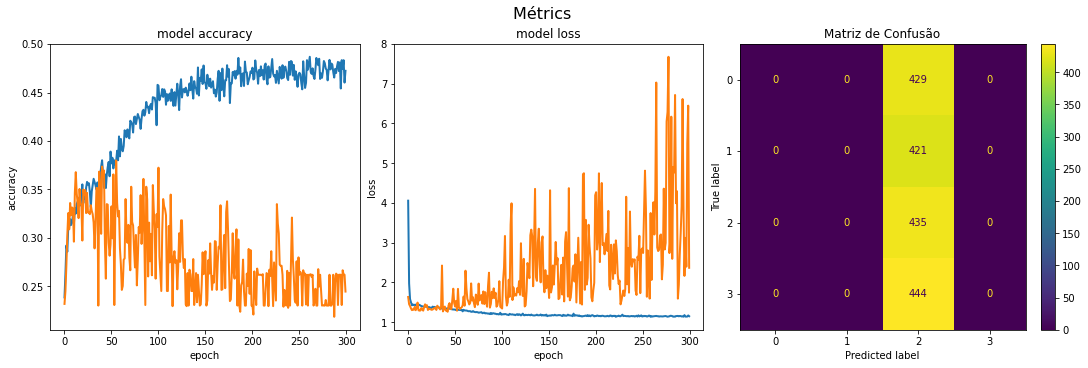

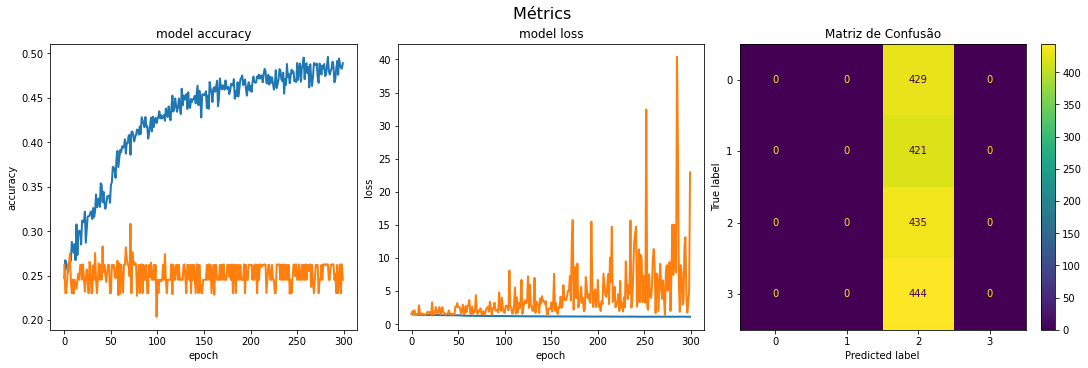

In [9]:
directory = 'C:/Users/Maods/Documents/TCC/data/eeg-motor-movementimagery-dataset/files/'
extension = '**/*.edf'

x_movementimagery, y_movementimagery  = load_eeg_data_edf(directory, extension)
nb_classes = np.unique(y_movementimagery).shape[0]
_, channels, samples = np.shape(x_movementimagery)
run_pipeline(x_movementimagery, y_movementimagery, nb_classes=nb_classes, chans=channels, samples=samples, dataset="eeg-mi", subject='all', metrics_results=metrics_results, kernels=1, epochs=300)

### 2. Training the subjects' data separately

In [10]:
directory = 'C:/Users/Maods/Documents/TCC/data/eeg-motor-movementimagery-dataset/files/'
extension = '**/*.edf'
files = [ file.name for file in Path(directory).glob('**/*') if len(file.name) == 4]
for file in files:
    x_movementimagery, y_movementimagery  = load_eeg_data_edf(directory + file, extension)
    nb_classes = np.unique(y_movementimagery).shape[0]
    if nb_classes != 4 or len(np.shape(x_movementimagery)) < 3:
        continue
    _, channels, samples = np.shape(x_movementimagery)

    run_pipeline(x_movementimagery, y_movementimagery, nb_classes=nb_classes, chans=channels, samples=samples, dataset="eeg-mi", subject=file, metrics_results=metrics_results, kernels=1, epochs=300)

Extracting EDF parameters from C:\Users\Maods\Documents\TCC\data\eeg-motor-movementimagery-dataset\files\S001\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 113 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\Maods\Documents\TCC\data\eeg-motor-movementimagery-dataset\files\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
EEG channel type selected for re-referencing
Applyi

c:\Users\Maods\Documents\Repos\EEG-Analysis-\src\utils\plots.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15,5))


Reading 0 ... 19679  =      0.000 ...   122.994 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 15 events and 113 original time points ...
0 bad epochs dropped
Extracting EDF parameters from C:\Users\Maods\Documents\TCC\data\eeg-motor-movementimagery-dataset\files\S009\S009R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
15 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applyin

In [ ]:
result = pd.DataFrame(metrics_results)
result.sort_values(['acc_test','acc_val'], ascending=False).head(30)

In [ ]:

result.to_csv('./artifacts/cnn_models_results.csv', index=False, header=True)